# Example Code for the Pileup OFs
-----
Import `qetpy` and other necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
from scipy import interpolate, special

from matplotlib import rc
rc('text', usetex=True)
rc('font', family="serif")
rc('axes', labelsize=12)
rc('font', size=12)
rc('legend', fontsize=10)
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)

np.random.seed(0)

## Use `QETpy` to generate some simulated TES noise

We can use `qetpy.sim.TESnoise` to help create a simulated PSD with characteristic TES parameters.

In [2]:
fs = 625e3
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(r0=0.03)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

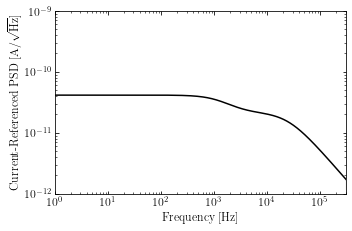

In [3]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))
ax.loglog(f_fold, psd_sim_fold**0.5, color="k", alpha=1, label="Simulated PSD, No Spikes")
ax.set_ylim(1e-12,1e-9)
ax.set_xlim(1, 3e5)
# ax.grid()
# ax.grid(which="major", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
# ax.legend(loc="best")
# ax.set_title("Simulated Current PSD")
ax.set_ylabel(r"Current-Referenced PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()
# fig.savefig('figs/example_psd.eps', facecolor='none')

With a PSD, we can use `qetpy.gen_noise` to generate random noise from the PSD (assuming the frequencies are uncorrelated). Then, we will create an example pulse.

In [4]:
# create a template
pulse_amp = 1e-6 # [A]
tau_f = 66e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

# use the PSD to create an example trace to fit
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 100)*pulse_amp # note the shift we have added, 160 us

Plot the pulse

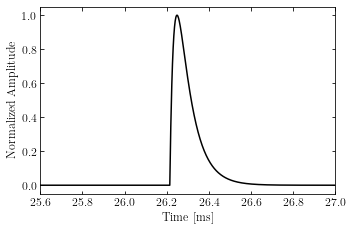

In [5]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

ax.plot(
    t*1e3,
    template,
    color="k",
)

ax.set_ylabel(r"Normalized Amplitude")
ax.set_xlabel(r"Time [ms]")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.set_xlim(25.6, 27)
fig.tight_layout()
# fig.savefig('figs/example_template.eps', facecolor='none')

Let's run the Optimum Filter without and with a time-shifting degree of freedom.

In [6]:
OF = qp.OptimumFilter(signal, template, psd_sim, fs) # initialize the OptimumFilter class
amp_nodelay, chi2_nodelay = OF.ofamp_nodelay()
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay()

print(f"No Delay Fit: amp = {amp_nodelay*1e6:.2f} μA, χ^2 = {chi2_nodelay:.2f}")
print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")

No Delay Fit: amp = -0.04 μA, χ^2 = 210881.73
With Delay Fit: amp = 1.00 μA, t_0 = 160.0 μs, χ^2 = 32414.37


Since we have added a 160 us shift, we see that the "with delay" optimum filter fit the time-shift perfectly, and the chi-squared is very close to the number of degrees of freedom (32768), as we would expect for a good fit.

We'll plot the extracted pulse amplitudes for each fit and the optimal filtered trace.

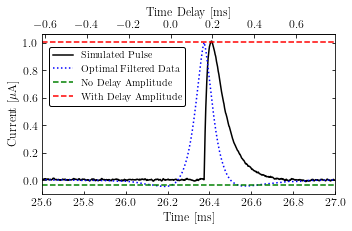

In [7]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))
ax.plot(
    t*1e3,
    signal*1e6,
    label="Simulated Pulse",
    color="k",
)


ax.plot(
    t*1e3,
    np.roll(OF.signalfilt_td, OF.nbins//2)*1e6,
    label="Optimal Filtered Data",
    color="b",
    linestyle="dotted",
)


ax.axhline(
    amp_nodelay * 1e6,
    label="No Delay Amplitude",
    color="g",
    linestyle="dashed",
)
ax.axhline(
    amp_withdelay * 1e6,
    label="With Delay Amplitude",
    color="r",
    linestyle="dashed",
)


ax2 = ax.secondary_xaxis(
    'top',
    functions=(lambda x: x - (32768//2/fs) * 1e3, lambda x: x + (32768//2/fs) * 1e3),
)

ax2.set_xlabel('Time Delay [ms]')

ax.set_ylabel(r"Current [$\mu$A]")
ax.set_xlabel(r"Time [ms]")
lgd = ax.legend(loc=(0.025,0.55), edgecolor='k', framealpha=1)
ax.tick_params(which="both", direction="in", right=True, top=False)
ax2.tick_params(which="both", direction="in", top=True)
ax.set_xlim(25.6, 27)
fig.tight_layout()
# fig.savefig('figs/example_of.eps', facecolor='none')

## Add a pileup pulse and fit with `OptimumFilter`

Let's now add a second (pileup) pulse in order to see how we can use `ofamp_pileup_iterative`.

This algorithm looks for the largest pulse in the trace, fits it, then subtracts the fit out, and looks for a pulse again (as such it is iterative).

In [8]:
pileup = signal + np.roll(template, 1000)*pulse_amp

OF.update_signal(pileup) # update the signal in order to fit a new trace
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=300)
amp_pileup, t0_pileup, chi2_pileup = OF.ofamp_pileup_iterative(amp_withdelay, t0_withdelay)

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")
print(f"Pileup Fit: amp = {amp_pileup*1e6:.2f} μA, t_0 = {t0_pileup*1e6} μs, χ^2 = {chi2_pileup:.2f}")

With Delay Fit: amp = 1.00 μA, t_0 = 160.0 μs, χ^2 = 210277.52
Pileup Fit: amp = 1.00 μA, t_0 = 1600.0 μs, χ^2 = 32414.72


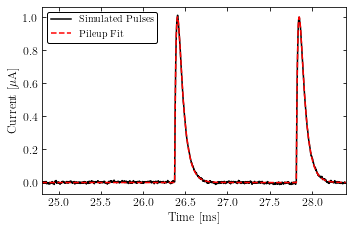

In [9]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

ax.plot(
    t*1e3,
    pileup*1e6,
    label="Simulated Pulses",
    color="k",
)
ax.plot(
    t*1e3,
    amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6 + amp_pileup*np.roll(template, int(t0_pileup*fs))*1e6, 
    label="Pileup Fit",
    color="red",
    linestyle="dashed",
)

ax.set_ylabel(r"Current [$\mu$A]")
ax.set_xlabel(r"Time [ms]")
ax.set_xlim(24.8, 28.4)
lgd = ax.legend(loc="upper left", edgecolor='k', framealpha=1)
ax.tick_params(which="both", direction="in", right=True, top=True)
fig.tight_layout()

This fits well and has an good $\chi^2$! What would happen if the pulses were closer together?

# Iterative Pileup OF fails

Let's add a pulse that will overlap with the main pulse.

In [10]:
pileup = signal + np.roll(template, 140)*pulse_amp

OF.update_signal(pileup) # update the signal in order to fit a new trace
amp_withdelay, t0_withdelay, chi2_withdelay = OF.ofamp_withdelay(nconstrain=300)
amp_pileup, t0_pileup, chi2_pileup = OF.ofamp_pileup_iterative(amp_withdelay, t0_withdelay)

print(f"With Delay Fit: amp = {amp_withdelay*1e6:.2f} μA, t_0 = {t0_withdelay*1e6} μs, χ^2 = {chi2_withdelay:.2f}")
print(f"Pileup Fit: amp = {amp_pileup*1e6:.2f} μA, t_0 = {t0_pileup*1e6} μs, χ^2 = {chi2_pileup:.2f}")

With Delay Fit: amp = 1.30 μA, t_0 = 169.6 μs, χ^2 = 187237.17
Pileup Fit: amp = 0.79 μA, t_0 = 224.0 μs, χ^2 = 75346.13


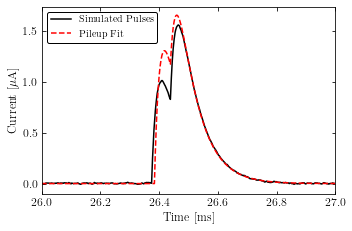

In [11]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

ax.plot(
    t*1e3,
    pileup*1e6,
    label="Simulated Pulses",
    color="k",
)
ax.plot(
    t*1e3,
    amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6 + amp_pileup*np.roll(template, int(t0_pileup*fs))*1e6, 
    label="Pileup Fit",
    color="red",
    linestyle="dashed",
)

ax.set_ylabel(r"Current [$\mu$A]")
ax.set_xlabel(r"Time [ms]")
ax.set_xlim(26, 27)
lgd = ax.legend(loc="upper left", edgecolor='k', framealpha=1)
ax.tick_params(which="both", direction="in", right=True, top=True)
fig.tight_layout()

The $\chi^2$ is poor, and the fit is clearly not good. The iterative pileup OF will not work well in this scenario.

# Simultaneous Pileup OF

There is also the class `qetpy.PileupOF`, which runs a version of the OF where the pulse amplitudes and start times are all fit simultaneously. However, due to computational reasons, we cannot look at all possible start times, but will restrict ourselves to the region around where a pulse likely is. See the source code for more info.

In [12]:
POF = qp.PileupOF(
    pileup,
    template,
    psd_sim,
    fs,
)
amp0, t00, amp1, t11, chi201 = POF.run()
print(f"Simultaneous Pileup Fit: amp0 = {amp0*1e6:.2f} μA, t00 = {t00*1e6} μs,"
      f"amp1 = {amp1*1e6:.2f} μA, t11 = {t11*1e6} μs, χ^2 = {chi201:.2f}"
     )

Simultaneous Pileup Fit: amp0 = 0.99 μA, t00 = 160.0 μs,amp1 = 0.99 μA, t11 = 224.0 μs, χ^2 = 32463.79


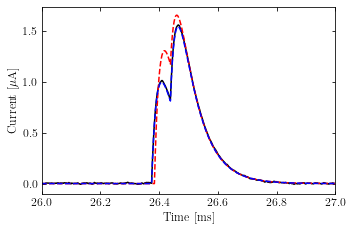

In [13]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

ax.plot(
    t*1e3,
    pileup*1e6,
    label="Simulated Pulses",
    color="k",
)
ax.plot(
    t*1e3,
    amp_withdelay*np.roll(template, int(t0_withdelay*fs))*1e6 + amp_pileup*np.roll(template, int(t0_pileup*fs))*1e6, 
    label="Iter. Pileup Fit",
    color="r",
    linestyle="dashed",
)


ax.plot(
    t*1e3,
    amp0*np.roll(template, int(t00*fs))*1e6 + amp1*np.roll(template, int(t11*fs))*1e6, 
    label="Simult. Pileup Fit",
    color="b",
    linestyle="dashed",
)

ax.set_ylabel(r"Current [$\mu$A]")
ax.set_xlabel(r"Time [ms]")
ax.set_xlim(26, 27)
# lgd = ax.legend(loc="upper right", edgecolor='k', framealpha=1)
ax.tick_params(which="both", direction="in", right=True, top=True)
fig.tight_layout()

The simultaneous pileup OF works quite well, and had a good $\chi^2$. It does take noticeably longer than the iterative version, which is the cost of increasing the dimensionality of the $\chi^2$ minimization. This OF only supports two pulses though, more pulses than that become too computationally intensive to calculate.

# Differential Evolution Pileup

We can fit for more than two pileup pulses with `qetpy.PileupDE`. This function is based on restricting the range of values to search for, and using `scipy.optimize.differential_evolution` to carry out the $\chi^2$ minimization stochastically. Below we show an example for 3 pulses being reconstructed

In [14]:
pileup3 = signal + np.roll(template, 140) * pulse_amp + np.roll(template, 180) * pulse_amp

In [15]:
DOF = qp.PileupDE(
    pileup3,
    template,
    psd_sim,
    fs,
)
res_de = DOF.run(
    3,
    # fit_window=(-100, 500), # able to set any range of values to search over, in terms of shift indices of template
)

print(f"PileupDE Fit: amp0 = {res_de[0]*1e6:.2f} μA, t00 = {res_de[1]*1e6:.1f} μs,"
      f"amp1 = {res_de[2]*1e6:.2f} μA, t11 = {res_de[3]*1e6:.1f} μs,"
      f"amp2 = {res_de[4]*1e6:.2f} μA, t22 = {res_de[5]*1e6:.1f} μs, χ^2 = {res_de[6]:.2f}"
     )

PileupDE Fit: amp0 = 1.00 μA, t00 = 160.0 μs,amp1 = 1.00 μA, t11 = 224.0 μs,amp2 = 1.00 μA, t22 = 288.0 μs, χ^2 = 32407.39


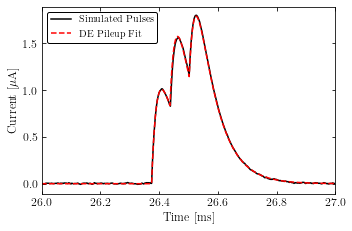

In [16]:
fig, ax = plt.subplots(figsize=(3 + 3/8) * np.array([1.5, 1]))

ax.plot(
    t*1e3,
    pileup3*1e6,
    label="Simulated Pulses",
    color="k",
)

ax.plot(
    t*1e3,
    sum(a * np.roll(template, int(t0 * fs)) for a, t0 in zip(res_de[:-1:2], res_de[1:-1:2]))*1e6, 
    label="DE Pileup Fit",
    color="r",
    linestyle="dashed",
)

ax.set_ylabel(r"Current [$\mu$A]")
ax.set_xlabel(r"Time [ms]")
ax.set_xlim(26, 27)
lgd = ax.legend(loc="upper left", edgecolor='k', framealpha=1)
ax.tick_params(which="both", direction="in", right=True, top=True)
fig.tight_layout()

This fits quite well and doesn't take too long to minimize! It can minimize faster if we were to lower the extent of `fit_window`.